In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import os

In [60]:
categories=['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

In [61]:
train_dir = '/content/drive/My Drive/Brain Tumor Classification (MRI)/Training'
test_dir = '/content/drive/My Drive/Brain Tumor Classification (MRI)/Testing'

In [62]:

# these are generators for train/test data that will read pictures #found in the defined subfolders of 'data/'


LR = 1e-5
height=150
width=150
channels=3
seed=1337
batch_size = 64 #Number of images to load at each iteration
num_classes = 4
epochs = 200
data_augmentation = True
num_predictions = 20

# Training generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='categorical')

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical')

train_num = train_generator.samples
validation_num = validation_generator.samples
validation_num

Found 2870 images belonging to 4 classes.
Found 1214 images belonging to 4 classes.
Found 1214 images belonging to 4 classes.


1214

In [63]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(height, width, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [64]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_28 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_29 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 36, 36, 64)       

In [67]:
filepath=str(os.getcwd()+"/model_brain.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# = EarlyStopping(monitor='val_acc', patience=15)
callbacks_list = [checkpoint]#, stopper]

In [68]:
history = model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=epochs,
                              validation_data=train_generator,
                              validation_steps= validation_num // batch_size,
                              callbacks=callbacks_list, 
                              verbose = 1
                             )

Epoch 1/200
44/44 [==============================] - ETA: 0s - loss: 1.1493 - accuracy: 0.4829
Epoch 00001: val_accuracy improved from -inf to 0.50174, saving model to /content/model_brain.h5f
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/model_brain.h5f/assets
44/44 [==============================] - 34s 777ms/step - loss: 1.1493 - accuracy: 0.4829 - val_loss: 1.1159 - val_accuracy: 0.5017
Epoch 2/200
44/44 [==============================] - ETA: 0s - loss: 1.0895 - accuracy: 0.5182
Epoch 00002: val_accuracy improved from 0.50174 to 0.53038, saving model to /content/model_brain.h5f
INFO:tensorflow:Assets written to: /content/model_brain.h5f/assets
44/44 [==============================] - 34s 767ms/step - loss: 1.0895 - accuracy: 0.5182 - val_loss: 1.0371 - 

In [69]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import matplotlib.pyplot as plt
from sklearn import metrics 
%matplotlib inline
model_trained = load_model(filepath)
# Predict the values from the validation dataset
Y_pred = model_trained.predict_generator(validation_generator, validation_num // batch_size+1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
#Y_true = np.argmax(validation_generator.classes,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = validation_generator.classes,y_pred = Y_pred_classes)
# plot the confusion matrix
confusion_mtx

Instructions for updating:
Please use Model.predict, which supports generators.


array([[209,  31,  53,   7],
       [  2, 288,  17,   8],
       [  0,   0, 304,   0],
       [  1,   5,  22, 267]])

In [83]:
Y_pred = model_trained.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([0, 0, 0, ..., 3, 3, 3])

In [84]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn import metrics
accuracy = accuracy_score(test_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 88.0% 


In [77]:
class_labels = list(test_generator.class_indices.keys()) 
class_labels

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [79]:
print(metrics.classification_report(validation_generator.classes, Y_pred_classes,target_names=class_labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.70      0.82       300
meningioma_tumor       0.89      0.91      0.90       315
        no_tumor       0.77      1.00      0.87       304
 pituitary_tumor       0.95      0.91      0.93       295

        accuracy                           0.88      1214
       macro avg       0.90      0.88      0.88      1214
    weighted avg       0.90      0.88      0.88      1214



In [80]:
path='/content/drive/My Drive/Brain_Tumor_save/'
model.save(path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Brain_Tumor_save/assets


In [100]:
#import library 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [101]:
from keras.applications import vgg16
model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(width, height, 3), pooling="max")

for layer in model.layers[:-5]:#freeze all layers except the last ten
        layer.trainable = False
#Check the trainable status of the individual layers        
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f13d2e0af28> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f13d2e185f8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f13d2e18358> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f13d2e18b70> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f13d3158780> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f13d2e87fd0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f13d2e24550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f13d2e1dda0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f13d2e1d320> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f13d2e2d7b8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f13d2e36ac8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [102]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential

# Although this part can be done also with the functional API, I found that for this simple models, this becomes more intuitive
transfer_model = Sequential()
for layer in model.layers:
    transfer_model.add(layer)
transfer_model.add(Dense(512, activation="relu"))  # Very important to use relu as activation function, search for "vanishing gradiends" :)
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(4, activation="softmax")) # Finally our activation layer! we use 10 outputs as we have 3 covid case(covid normal varial pnemoniea ) (labels)

transfer_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)      

In [103]:
from keras import optimizers
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001)

transfer_model.compile(loss="categorical_crossentropy",
                      optimizer=adam,
                      metrics=["accuracy"])

In [108]:
learning_rate = 5e-5

checkpoint = ModelCheckpoint("Brain_Tumor.h5", monitor = 'val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]


In [109]:
model_history = transfer_model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=100,
                              validation_data=train_generator,
                              validation_steps= validation_num // batch_size,
                             callbacks=[checkpoint], 
                              verbose = 1)


Epoch 1/100
44/44 [==============================] - ETA: 0s - loss: 1.0065 - accuracy: 0.5759
Epoch 00001: val_accuracy improved from -inf to 0.77431, saving model to Brain_Tumor.h5
44/44 [==============================] - 34s 778ms/step - loss: 1.0065 - accuracy: 0.5759 - val_loss: 0.6187 - val_accuracy: 0.7743
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 0.5585 - accuracy: 0.7851
Epoch 00002: val_accuracy improved from 0.77431 to 0.84288, saving model to Brain_Tumor.h5
44/44 [==============================] - 34s 763ms/step - loss: 0.5585 - accuracy: 0.7851 - val_loss: 0.4298 - val_accuracy: 0.8429
Epoch 3/100
44/44 [==============================] - ETA: 0s - loss: 0.4416 - accuracy: 0.8264
Epoch 00003: val_accuracy improved from 0.84288 to 0.85590, saving model to Brain_Tumor.h5
44/44 [==============================] - 34s 764ms/step - loss: 0.4416 - accuracy: 0.8264 - val_loss: 0.3927 - val_accuracy: 0.8559
Epoch 4/100
44/44 [==============================

In [110]:
for metric in model_history.history.keys():
    print(metric)

loss
accuracy
val_loss
val_accuracy


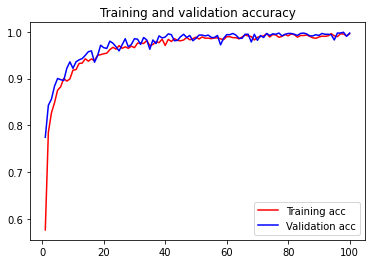

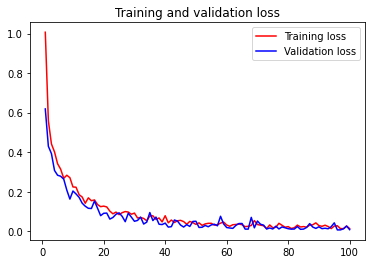

In [112]:
#Plot Training and validation accuracy and Training and validation loss
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [113]:
Y_pred = transfer_model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_pred
#validation_generator.classes

array([0, 0, 0, ..., 3, 3, 3])

In [114]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn import metrics
accuracy = accuracy_score(test_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 93.0% 


In [115]:
class_labels = list(test_generator.class_indices.keys()) 
class_labels

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [117]:
print(metrics.classification_report(validation_generator.classes, y_pred,target_names=class_labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.79      0.88       300
meningioma_tumor       0.87      0.99      0.93       315
        no_tumor       0.89      1.00      0.94       304
 pituitary_tumor       1.00      0.93      0.96       295

        accuracy                           0.93      1214
       macro avg       0.94      0.93      0.93      1214
    weighted avg       0.94      0.93      0.93      1214



In [118]:
path='/content/drive/My Drive/Covid_model_save/Brain_tumor_VGG16_93%.h5'
model.save(path)

In [ ]:
#Test Prediction of Image
import cv2
test_data=[]
test_image_o=cv2.imread('/content/drive/My Drive/Covid19-dataset/test/Viral Pneumonia/0104.jpeg')
test_image=cv2.resize(test_image_o,(width,height))# .flatten()
test_data.append(test_image)

# scale the raw pixel intensities to the range [0, 1]
test_data=np.array(test_image,dtype="float")/255.0
test_data=test_data.reshape([-1,width, height, 3])
pred = model_trained.predict_generator(test_data)
predictions =np.argmax(pred, axis=1) # return to label
print ('Prediction : '+categories[predictions[0]])

In [ ]:
#Imersing into the plot
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.title(categories[predictions[0]])
plt.imshow(test_image_o)